In [1]:
import scipy.io as sio
import torch
from sklearn.model_selection import KFold
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Subset
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
import segmentation_models_pytorch as smp # Unet
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
# --------------------
train_X = sio.loadmat("data/train/X.mat")["X"]  # (200, 90, 30)
train_Y = sio.loadmat("data/train/Y.mat")["Y"]
# --------------------
# Min-Max normalization
# --------------------
X_min, X_max = train_X.min(), train_X.max()
Y_min, Y_max = train_Y.min(), train_Y.max()

train_X_norm = (train_X - X_min) / (X_max - X_min)
train_Y_norm = (train_Y - Y_min) / (Y_max - Y_min)

# torch tensors
train_X_tensor = torch.tensor(train_X_norm, dtype=torch.float32).unsqueeze(1)
train_Y_tensor = torch.tensor(train_Y_norm, dtype=torch.float32).unsqueeze(1)
train_Y_tensor.shape

torch.Size([200, 1, 30, 90])

In [4]:
# Load data
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(train_X_tensor, train_Y_tensor)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [5]:
import torch.nn as nn
import segmentation_models_pytorch as smp

# SimpleCNN
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(SimpleCNN, self).__init__()
        
        # --- Encoder 
        self.conv1 = nn.Conv2d(in_channels, 32, 3, padding=1, stride=1) # 01 input , 32 filters, 3x3 sizes of filters
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1, stride=1)   # 32 inputs, 64, filters, 3x3 sizes of filters
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1, stride=1)  

        # --- Decoder 
        self.conv4 = nn.Conv2d(128, 64, 3, padding=1, stride=1)  
        self.conv5 = nn.Conv2d(64, 32, 3, padding=1, stride=1)
        self.conv6 = nn.Conv2d(32, out_channels, 3, padding=1, stride=1)
        
        # Shared utility layers
        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.act = nn.ReLU()

    def forward(self, x):
        # 1. ENCODER         
        x1 = self.pool(self.act(self.conv1(x)))        
        x2 = self.pool(self.act(self.conv2(x1)))        
        x3 = self.pool(self.act(self.conv3(x2)))        
        # ----------------------------------------------------        
        # 2. DECODER         
        x4 = self.up(self.act(self.conv4(x3)))
        
        x5 = self.up(self.act(self.conv5(x4)))
        
        x6 = self.up(self.conv6(x5))
        
        # Final safeguard to ensure exact size match
        x_out = F.interpolate(x6, size=x.shape[2:], mode='bilinear', align_corners=False)
        return x_out

# UNet: Pretrained model
def get_unet(in_channels=1, out_channels=1):
    return smp.Unet(
        encoder_name="resnet34", # : Pretrained model
        encoder_weights=None,  # or "imagenet"
        in_channels=in_channels,
        classes=out_channels)

In [6]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

def train_model(model, train_loader, epochs, lr=1e-3):
    model = model.to(device)
    criterion = nn.MSELoss() # My loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) # Adam optimizer with lr = 1e-3
    
    losses = []
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for X_batch, Y_batch in train_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            
            optimizer.zero_grad()
            Y_pred = model(X_batch)
            loss = criterion(Y_pred, Y_batch)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        epoch_loss /= len(train_loader)
        losses.append(epoch_loss)
        # Print only every 100 epochs
        if (epoch + 1) % 100 == 0 or epoch == 0:  # also print the first epoch
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.6f}")
    return losses

In [7]:
# ==========
epochs = 500
# Train Simple CNN
print("Start training of CNN:")
start_cnn = time.time()
simple_cnn = SimpleCNN()
cnn_losses = train_model(simple_cnn, train_loader, epochs)
end_cnn = time.time()
print("Training time of CNN:", (end_cnn - start_cnn), "seconds")
# Train UNet
print("Start training of UNet:")
start_unet = time.time()
unet_model = get_unet()
unet_losses = train_model(unet_model, train_loader, epochs)
end_unet = time.time()
print("Training time of Unet:", (end_unet - start_unet), "seconds")

Start training of CNN:
Epoch [1/500], Loss: 0.336887
Epoch [100/500], Loss: 0.096968
Epoch [200/500], Loss: 0.090168
Epoch [300/500], Loss: 0.089227
Epoch [400/500], Loss: 0.085424
Epoch [500/500], Loss: 0.085748
Training time of CNN: 119.16729307174683 seconds
Start training of UNet:
Epoch [1/500], Loss: 0.398797
Epoch [100/500], Loss: 0.024076
Epoch [200/500], Loss: 0.007570
Epoch [300/500], Loss: 0.004162
Epoch [400/500], Loss: 0.002542
Epoch [500/500], Loss: 0.002204
Training time of Unet: 940.4179441928864 seconds


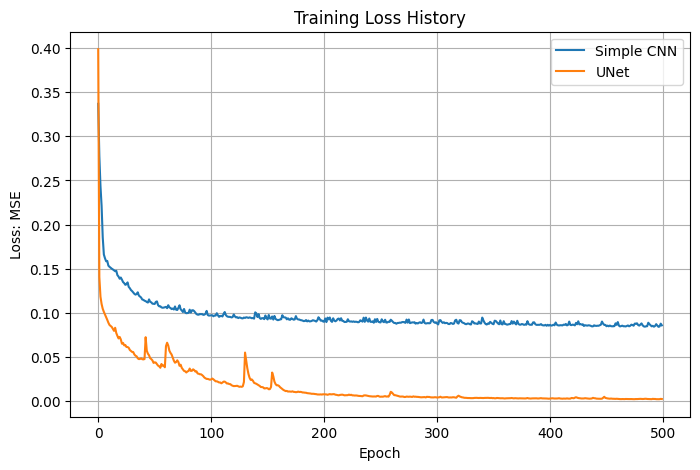

In [8]:
# Plotting loss of CNN and Unet
plt.figure(figsize=(8,5))
plt.plot(cnn_losses, label="Simple CNN")
plt.plot(unet_losses, label="UNet")
plt.xlabel("Epoch")
plt.ylabel("Loss: MSE")
plt.title("Training Loss History")
plt.legend()
plt.grid(True)
plt.savefig("Train_Hist_CNN_UNET.png", dpi=300, bbox_inches='tight')
plt.show()

In [9]:
# Save models
CNN_PATH = 'simple_cnn_weights.pth'
UNET_PATH = 'unet_model_weights.pth'
torch.save(simple_cnn, CNN_PATH)
torch.save(unet_model, UNET_PATH)
print(f"CNN model weights saved to: {CNN_PATH}")
print(f"U-Net model weights saved to: {UNET_PATH}")

CNN model weights saved to: simple_cnn_weights.pth
U-Net model weights saved to: unet_model_weights.pth


In [10]:
# load the save model
CNN_PATH = 'simple_cnn_weights.pth'
UNET_PATH = 'unet_model_weights.pth'
cnn_load = SimpleCNN()
cnn_load = torch.load(CNN_PATH, weights_only=False)
cnn_load.eval()
unet_load = get_unet()
unet_load = torch.load(UNET_PATH, weights_only=False)
unet_load.eval();

In [11]:
# Load testing data
val_X = sio.loadmat("data/val/X.mat")["X"]
val_Y = sio.loadmat("data/val/Y.mat")["Y"]
# Normalize using training min/max
val_X_norm = (val_X - X_min) / (X_max - X_min)
val_Y_norm = (val_Y - Y_min) / (Y_max - Y_min)
# Add channel dimension
val_X_tensor = torch.tensor(val_X_norm, dtype=torch.float32).unsqueeze(1).to(device)  # (N,1,H,W)
val_Y_tensor = torch.tensor(val_Y_norm, dtype=torch.float32).unsqueeze(1).to(device)
# -------------------------------
# predictions and MSE
# -------------------------------
def eval_model(model, X_tensor, Y_tensor):
    model.eval()
    with torch.no_grad():
        Y_pred = model(X_tensor)
    Y_pred_np = Y_pred.cpu().numpy()
    Y_pred_denorm = Y_pred_np * (Y_max - Y_min) + Y_min
    Y_true_denorm = Y_tensor.cpu().numpy() * (Y_max - Y_min) + Y_min
    mse = np.mean((Y_true_denorm - Y_pred_denorm)**2)
    
    SS_res = np.sum((Y_true_denorm - Y_pred_denorm)**2)
    Y_mean = np.mean(Y_true_denorm)
    SS_tot = np.sum((Y_true_denorm - Y_mean)**2)
    r2 = 1 - (SS_res / SS_tot)
        
    return Y_pred_denorm, Y_true_denorm, mse, r2 
# -------------------------------
# Evaluate both models
# -------------------------------
cnn_pred_denorm, Y_true_denorm, cnn_mse, cnn_r2 = eval_model(cnn_load, val_X_tensor, val_Y_tensor)
unet_pred_denorm, _, unet_mse, unet_r2 = eval_model(unet_load, val_X_tensor, val_Y_tensor)

print(f"CNN Testing MSE: {cnn_mse:.6f}")
print(f"UNet Testing MSE: {unet_mse:.6f}")

print(f"CNN Testing R2: {cnn_r2:.6f}")
print(f"UNet Testing R2: {unet_r2:.6f}")

CNN Testing MSE: 0.083545
UNet Testing MSE: 0.004044
CNN Testing R2: 0.615409
UNet Testing R2: 0.981383


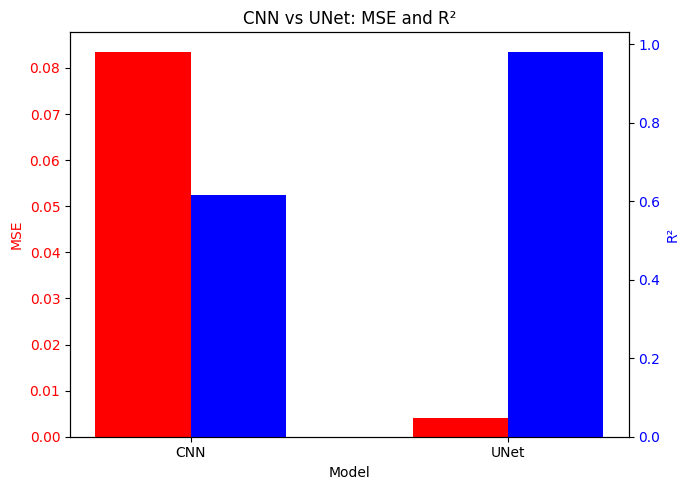

In [12]:
# Data
models = ["CNN", "UNet"]
mse = np.array([cnn_mse, unet_mse])
r2  = np.array([cnn_r2, unet_r2])


x = np.arange(len(models))

fig, ax1 = plt.subplots(figsize=(7,5))

# Left axis (MSE)
ax1.set_xlabel("Model")
ax1.set_ylabel("MSE", color="red")
ax1.bar(x - 0.15, mse, width=0.3, label="MSE", color="red")
ax1.tick_params(axis='y', labelcolor="red")

# Right axis (R2)
ax2 = ax1.twinx()
ax2.set_ylabel("R²", color="blue")
ax2.bar(x + 0.15, r2, width=0.3, label="R²", color="blue")
ax2.tick_params(axis='y', labelcolor="blue")

plt.xticks(x, models)
plt.title("CNN vs UNet: MSE and R²")
plt.tight_layout()
# Save to PNG
plt.savefig("MSE_R2_CNN_UNET.png", dpi=300, bbox_inches='tight')
plt.show()

In [13]:
import time
# Measure
start = time.time()
unet_load.eval()
Y_pred = unet_load(val_X_tensor)
end = time.time()
print("Inference time:", (end - start)/val_X_tensor.shape[0], "seconds")

Inference time: 0.002425994873046875 seconds


In [14]:
import time
# Measure
start = time.time()
cnn_load.eval()
Y_pred = cnn_load(val_X_tensor)
end = time.time()
print("Inference time:", (end - start)/val_X_tensor.shape[0], "seconds")

Inference time: 0.0006530952453613282 seconds


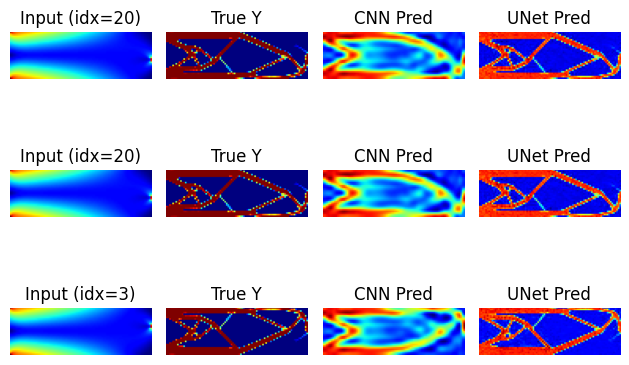

In [15]:
# Plot
no_pred = 3
sample_ids = np.random.randint(0, 50, no_pred)

fig, axes = plt.subplots(len(sample_ids),4)

for row, idx in enumerate(sample_ids):

    axes[row, 0].imshow(val_X[idx], cmap="jet")
    axes[row, 0].set_title(f"Input (idx={idx})")
    axes[row, 0].axis("off")

    axes[row, 1].imshow(Y_true_denorm[idx, 0], cmap="jet")
    axes[row, 1].set_title("True Y")
    axes[row, 1].axis("off")

    axes[row, 2].imshow(cnn_pred_denorm[idx, 0], cmap="jet")
    axes[row, 2].set_title("CNN Pred")
    axes[row, 2].axis("off")

    axes[row, 3].imshow(unet_pred_denorm[idx, 0], cmap="jet")
    axes[row, 3].set_title("UNet Pred")
    axes[row, 3].axis("off")

# Remove extra margins around the figure
fig.tight_layout()
plt.savefig("predictions_CNN_UNET.png", dpi=300,bbox_inches="tight")
plt.show()
